## Step 1

In [1]:
from pprint import pprint
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import shapely
import fiona
import geojson
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.warp
import matplotlib.pyplot as plt
import requests
import leafmap

In [2]:
sentinel_path = 'Kastoria/Kastoria.tif'
corine_path = 'Kastoria/Kast_RefData_26Classes.tif'
aoi_old_path = 'map.geojson'
aoi_new_path = 'map-correct-crs.geojson'
weather_path = 'POWER_Point_Daily_20140101_20210331_040d4636N_021d1577E_LST.json'

image_names = [
    '2016-01-25',
    '2016-02-14',
    '2016-03-28',
    '2016-04-04',
    '2016-04-27',
    '2016-06-06',
    '2016-07-03',
    '2016-07-13',
    '2016-07-23',
    '2016-07-26',
    '2016-08-05',
    '2016-08-12',
    '2016-08-15',
    '2016-08-22',
    '2016-09-04',
    '2016-09-14',
    '2016-10-01',
    '2016-10-14',
    '2016-11-13',
    '2016-12-03',
    '2016-12-10',
    '2016-12-20',
    '2016-12-23',
    '2016-12-30'
]

band_names = [
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'ndvi',
    'msavi',
    'ndwi',
    'ndbi'
]

In [3]:
len(image_names)

24

In [4]:
sentinel = rasterio.open(sentinel_path)
corine = rasterio.open(corine_path)

In [5]:
weather = gpd.read_file(weather_path)
weather.parameter[0].keys()

dict_keys(['ALLSKY_SFC_SW_DWN', 'T2M', 'QV2M', 'PRECTOTCORR', 'PS', 'WS10M'])

## Step 2

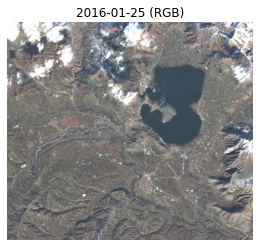

In [6]:
n_bands = 10
n_images = 24
rgb_bands = [3, 2, 1]
rgb_sentinel = sentinel.read(rgb_bands)  # Image of the first date
rgb_sentinel = rgb_sentinel.transpose((1, 2, 0))
plt.imshow(rgb_sentinel)
plt.axis('off')
plt.title('2016-01-25 (RGB)')
plt.show()

In [7]:
# CLIP THE DATA

# Read the aoi with geopandas, change the coordinates to match the raster, write in a new file
g = gpd.read_file(aoi_old_path)
sentinel_crs = sentinel.crs.to_epsg()
g = g.to_crs(epsg=sentinel_crs)
g.to_file(aoi_new_path, driver="GeoJSON")

with fiona.open(aoi_new_path) as gj:
    aoi = [feature['geometry'] for feature in gj]
    aoi_crs = gj.crs
    
masked, masked_transform = rasterio.mask.mask(sentinel, aoi, crop=True, nodata=np.nan)

In [8]:
# # Calculate the area of the raster
# b = sentinel.bounds
# polygon = shapely.geometry.Polygon([
#     [b.left, b.top],
#     [b.right, b.top],
#     [b.right, b.bottom],
#     [b.left, b.bottom],
# ])
# original_area = gpd.GeoDataFrame({'geometry':[polygon]}, crs=sentinel_crs).area[0]

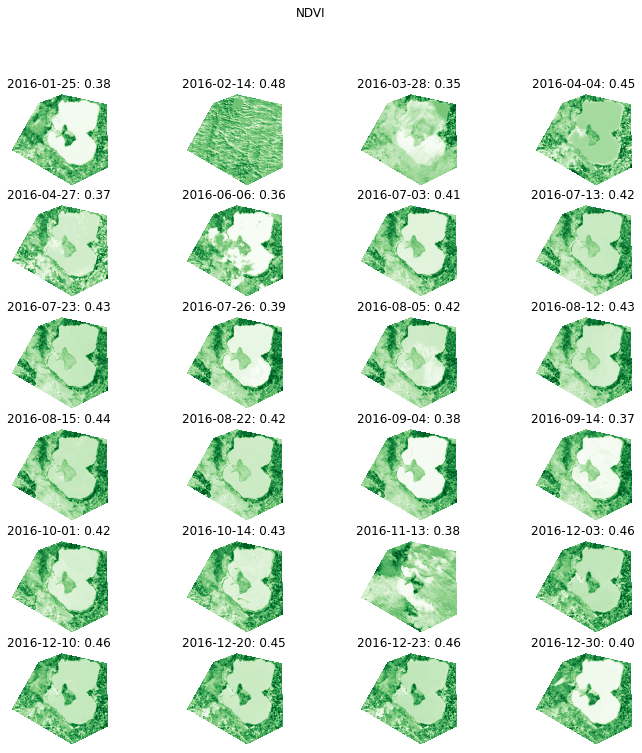

In [9]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(12, 12))
band = 7  # NDVI
cmap = 'Greens'
img_means = []
for ax, (image_id, image_name) in zip(axs.flat, enumerate(image_names, 1)):
    image_band_idx = (image_id - 1) * n_bands + band
    img = masked[image_band_idx]
    img_mean = np.nanmean(img)
    img_means.append(img_mean)
    ax.imshow(img, cmap=cmap)
    ax.set_axis_off()
    ax.set_title(f'{image_name}: {img_mean:.2f}')

fig.suptitle('NDVI')
plt.show()

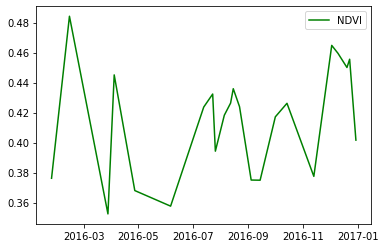

In [10]:
plt.plot(
    [datetime.date.fromisoformat(image_name) for image_name in image_names],
    img_means,
    color='green',
    label='NDVI'
)
plt.legend()
plt.show()

## Step 3

In [11]:
# url = 'http://geodata.gov.gr/geoserver/ows?service=WMS&request=GetCapabilities'
# r = requests.get(url)
# root = ET.fromstring(r.text)
# tree = ET.ElementTree(root)
# tree.write('response.xml')

#########################################

# url = 'http://geodata.gov.gr/geoserver/ows'

# params = dict(
#     service='WMS',
#     request='GetMap',
#     version='1.3.0',
#     WIDTH=256,
#     HEIGHT=256,
#     format='image/png',
#     srs='EPSG:32634',
#     bbox='38.007621,23.827829,38.200911,23.98585',
#     layers='geodata.gov.gr:8a52d712-d348-4df0-9960-856120a47f02'
# )

# r = requests.get(url, params=params)

# # /greece_bounding_box = (20.1500159034, 34.9199876979, 26.6041955909, 41.8269046087)


In [62]:
def wfs_geodatagov(typeName, crs):
    url = 'http://geodata.gov.gr/geoserver/ows'
    params = dict(service='WFS', version='2.0.0', request='GetFeature', srsName=f'EPSG:{crs}', outputFormat='json')
    params['typeName'] = typeName
    r = requests.get(url, params=params)
    features = geojson.loads(r.text)
    df = gpd.GeoDataFrame.from_features(features, crs=crs)
    return df


# EPGS:32634 uses meters for coordinates, which means we can meters as buffer distance
crs = 3264
police_typeName = 'geodata.gov.gr:9603c9bb-fa1c-4272-beb5-2a21204da56b'
schools_typeName = 'geodata.gov.gr:11009351-71ec-47f1-9da5-282f04b72a80'
churches_typeName = 'geodata.gov.gr:8ae90a8d-ab68-4c0a-8153-45cab12ee57a'

police = wfs_geodatagov(police_typeName, crs)
schools = wfs_geodatagov(schools_typeName, crs)
churches = wfs_geodatagov(churches_typeName, crs)

athens = gpd.read_file('dasynoikies')
athens = athens.to_crs(crs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Schools (blue) and Church regions (red)'}>

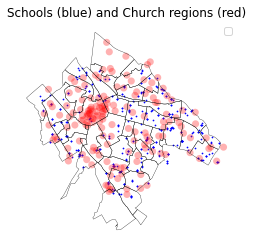

In [63]:
fig, ax = plt.subplots()
athens.boundary.plot(ax=ax, color='black', linewidth=0.3)
schools.plot(ax=ax, color='blue', markersize=0.5)
churches.buffer(800).plot(ax=ax, alpha=0.3, color='red')
ax.legend()
ax.set_title('Schools (blue) and Church regions (red)')
ax.set_axis_off()
ax

In [61]:
schools_near_church = schools.within(churches.buffer(800).unary_union).mean()
print(f'Percentage of schools within 800 meters of a church: {schools_near_church: .2%}')

Percentage of schools within 800 meters of a church:  36.64%


In [15]:
no_schools_nearby = athens.unary_union.difference(schools.buffer(1000).unary_union).area / athens.unary_union.area
print(f'{no_schools_nearby: .2%} of the Athens region does not have a school withion 1 km')

 55.34% of the Athens region does not have a school withion 1 km


Text(0.5, 1.0, 'Schools colored by their regions')

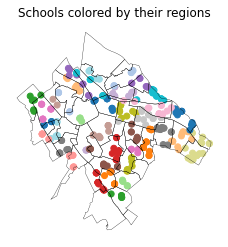

In [72]:
# Find the administrative region of each school
joined = schools.sjoin(athens, how='inner', predicate='intersects')
# Plot the schools and color them according to their region
fig, ax = plt.subplots()
athens.boundary.plot(color='black', linewidth=0.3, ax=ax)
joined.plot(column='SINIKIA_EN', cmap='tab20', ax=ax)
ax.set_axis_off()
ax.set_title('Schools colored by their regions')